In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx

# Market Basket Analysis
This Analysis relies on purchase history to extract items that usually are bought together. In other words they are a basket. This would provide us with rich information about the connection between different products and what Baskets the clients look for.

**Marketing Aspect**

1. The results provide information that can be leveraged to incentivize customers to purchase more items. Or even to keep them loyal to the business. There are many methods for this. As an example, if beer is usually bought with chips, and there is huge sale of beer, we can promote the beer/chips combo to encourage the purchase of chips.
2. This analysis can also be used in detecting different group of customers with different behaviors. This will be pivotal in Customer Oriented Strategies.

## Load Data

In [2]:
# Specify the path to the cutomer_data folder in the parent directory
working_directory = "B:/Projects/Marketing Analytics Project/Marketing-Analysis-unimib/"
data_folder_path = "../Data/"

In [3]:
# Read the cutomer_cutomer_cutomer_data file using pandas
customer_accounts_data = pd.read_csv(data_folder_path + "tbl_customer_accounts.csv")
adresses_data = pd.read_csv(data_folder_path + "tbl_addresses.csv")
customer_data = pd.read_csv(data_folder_path + "tbl_customers.csv")
orders_data = pd.read_csv(data_folder_path + "tbl_orders.csv")
products_data = pd.read_csv(data_folder_path + "tbl_products.csv")
customer_reviews_data = pd.read_csv(data_folder_path + "tbl_customer_reviews.csv")
labelled_reviews_data = pd.read_csv(data_folder_path + "tbl_labelled_reviews.csv")

## Analysis

### Create the dataset

In [6]:
# Preprocess data to create transactions
# Merge orders with products to get product names
orders_products = pd.merge(orders_data, products_data, on='product_id')
orders_products.head()

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.4,0.00,2022-10-04T182851,6
1,bfe77aedcfc4098926ad5b133cec4a1d,900,18,35551922,1,229.9,22.99,2023-01-08T135407,6
2,0785791dd07b165a9af7729a91c61689,1215,49,35551922,1,41.8,0.00,2022-08-26T195230,6
3,1b3e6d9fcbbe3890c2c0e36a27f49f3b,1351,22,35551922,1,647.9,64.79,2022-09-29T145226,6
4,97f7846be121869a143c060ad5dbdd02,1351,22,35551922,1,62.7,0.00,2022-12-05T085201,6


### Lets take a look at Why a very low threshold is required for extracting item sets.
1. First hypo is that there are lots of transactions that do not involve many products. this reduces their support to very low values.

There are orders that have more than 1 of any product.

In [9]:
# Preprocess the data to find the maximum count of each item in any order
# Group by order_id and product_id, then count the occurrences of each product in each order
order_product_counts = orders_data.groupby(['order_id', 'product_id']).size().reset_index(name='count')

# Find the maximum count of each product across all orders
max_item_counts = order_product_counts.groupby('product_id')['count'].max().reset_index()

## Sort
max_item_counts = max_item_counts.sort_values('count', ascending=False)

# Display the maximum count of each item
print(max_item_counts)

      product_id  count
1096    35662515   1568
315     32981935   1250
788     35143276   1024
1877    48011971   1024
300     32842551   1024
...          ...    ...
1582    36236186      1
461     34008142      1
460     34008121      1
796     35156163      1
797     35156170      1

[2000 rows x 2 columns]


Now we need to calculate support for each item.

In [12]:
# Preprocess the data to create transactions
# Group by order_id and product_id to remove duplicates within the same order
unique_orders_products = orders_data[['order_id', 'product_id']].drop_duplicates()

# Calculate the support for each item
total_transactions = unique_orders_products['order_id'].nunique()
item_counts = unique_orders_products['product_id'].value_counts()
item_support = item_counts / total_transactions

# Convert the result to a DataFrame
item_support_df = item_support.reset_index()
item_support_df.columns = ['product_id', 'support']

# Sort the DataFrame by support
item_support_df = item_support_df.sort_values('support', ascending=False)

# Display the item support DataFrame
print(item_support_df)

      product_id   support
0       33700716  0.099813
1       33817091  0.044182
2       34843564  0.022442
3       32882024  0.011702
4       35209202  0.008685
...          ...       ...
1995    35805126  0.000065
1996    32093992  0.000059
1997    81259510  0.000051
1998    48010326  0.000038
1999    36560713  0.000032

[2000 rows x 2 columns]


Histogram of Item count in each Basket

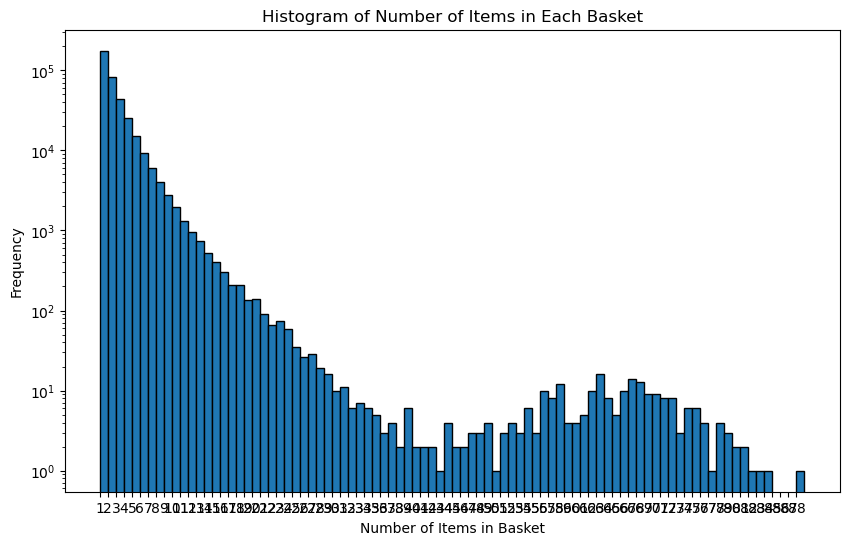

In [17]:
# Preprocess the data to create transactions
# Group by order_id and product_id to remove duplicates within the same order
unique_orders_products = orders_data[['order_id', 'product_id']].drop_duplicates()

# Count the number of items in each basket
transaction_item_count = unique_orders_products.groupby('order_id').size().reset_index(name='count')

# Plot a histogram of the number of items found in each basket
plt.figure(figsize=(10, 6))
plt.hist(transaction_item_count['count'], bins=range(1, transaction_item_count['count'].max() + 2), edgecolor='black', log=True)
plt.xlabel('Number of Items in Basket')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Items in Each Basket')
plt.xticks(range(1, transaction_item_count['count'].max() + 1))
plt.show()

In [18]:
# Preprocess the data to create transactions
# Group by order_id and product_id to remove duplicates within the same order
unique_orders_products = orders_data[['order_id', 'product_id']].drop_duplicates()

# Count the number of items in each basket
transaction_item_count = unique_orders_products.groupby('order_id').size().reset_index(name='count')

# Filter for transactions that have exactly one item
single_item_transactions = transaction_item_count[transaction_item_count['count'] == 1]

# Merge to get the product_ids that appear in these single-item baskets
single_item_products = unique_orders_products.merge(single_item_transactions[['order_id']], on='order_id')

# Count the number of baskets for each product that appears only solo
solo_item_counts = single_item_products['product_id'].value_counts().reset_index()
solo_item_counts.columns = ['product_id', 'solo_basket_count']

# Display the list of products that only appear solo in transactions along with their counts
print(solo_item_counts)

      product_id  solo_basket_count
0       33700716               6427
1       33817091               2489
2       48020504               1673
3       81274743               1608
4       81274749               1182
...          ...                ...
1994    36304625                  2
1995    36657873                  1
1996    36657922                  1
1997    36657901                  1
1998    36658650                  1

[1999 rows x 2 columns]


### Encode

In [7]:
# Group by order_id to create transactions
transactions = orders_products.groupby('order_id')['product_id'].apply(list).tolist()
transactions

[[81273876],
 [34916056],
 [36238020, 33651121, 35874272],
 [35212254, 35160741],
 [35874006, 36531131],
 [48090826],
 [36175566],
 [35799155],
 [36635606],
 [32988382, 31618300, 31618321],
 [36635606, 33250532],
 [35925050],
 [81263845],
 [35723926, 36076145],
 [35121730],
 [36163183],
 [34389250, 32697266, 36276954],
 [34320314],
 [34985104, 34985104],
 [36588265, 36588251],
 [32657863],
 [35272153, 35535934],
 [32581101, 32580646],
 [36542422],
 [34843564, 81259448, 81259526, 36276513, 81259450],
 [36319311, 32444160],
 [34010823, 36483461],
 [32332461, 31047275, 34285461],
 [33868681],
 [35963396],
 [34843564],
 [36085462, 33120913],
 [30126306],
 [31257443, 33700716, 32450082],
 [35895503],
 [36530291, 31193890, 35761670],
 [36550290,
  31419136,
  36135855,
  35659015,
  35738836,
  34499241,
  33787621,
  35848120],
 [35575155, 35575176],
 [36541106, 35196196, 35265692],
 [35099736],
 [33892614],
 [33700716, 32224122],
 [34008142, 35295624],
 [33700716, 32851406, 36046346],
 [35

In [8]:
# Use TransactionEncoder to transform the transaction data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transactions_df = pd.DataFrame(te_ary, columns=te.columns_)
print(transactions_df.head().to_string())

   504553    30033521  30044455  30062452  30072014  30097186  30097291  30097340  30099454  30126292  30126306  30153872  30156203  30293340  30293354  30293361  30310266  30310273  30310280  30326730  30326870  30327542  30327682  30328375  30329621  30329663  30344384  30344391  30385502  30409491  30409512  30409624  30410366  30410415  30410541  30410765  30475151  30475165  30482683  30490404  30513721  30573746  30574635  30627401  30630642  30634065  30634464  30676191  30691773  30699102  30714810  30749243  30809730  30886730  30886765  30935464  30990134  31002643  31004225  31041766  31041780  31041850  31041885  31045525  31047254  31047275  31047331  31047345  31047352  31047366  31047373  31047401  31047415  31047436  31047443  31047450  31047464  31047471  31047485  31047492  31047520  31047625  31047751  31047772  31056305  31056312  31082443  31087273  31125675  31128321  31136483  31182130  31182144  31193890  31193904  31194464  31197551  31209192  31209255  3120969

### MBA Analysis

#### Frequent Item Sets

In [35]:
# Apply Apriori Algorithm
# Set a minimum support threshold as required, e.g., 0.01 for 1%
frequent_itemsets = apriori(transactions_df, min_support=0.0023, use_colnames=True)
print("Frequent Itemsets:\n", frequent_itemsets)

MemoryError: Unable to allocate 4.29 GiB for an array with shape (371804, 12403) and data type bool

In [24]:
frequent_itemsets.tail(20)

,support,itemsets
140,0.002590,"(31618405, 32988382)"
141,0.003833,"(31618405, 34129942)"
142,0.003131,"(32078795, 32078935)"
143,0.003757,"(32079082, 32078795)"
144,0.003865,"(32078795, 32079103)"
145,0.003115,"(32078970, 32078935)"
146,0.003994,"(32079082, 32078935)"
147,0.004497,"(32079103, 32078935)"
148,0.002574,"(32078970, 32079082)"
149,0.003055,"(32078970, 32079103)"


#### Association Rules

In [27]:
# Generate Association Rules
# Set minimum thresholds for confidence and lift as required
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)

# Add lift to the rules
rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])

# Output the results

print("\nAssociation Rules:\n", rules)


Association Rules:
              antecedents consequents  antecedent support  consequent support  \
43            (36298381)  (36298353)            0.003467            0.003967   
42            (36298353)  (36298381)            0.003967            0.003467   
0             (31047464)  (31047485)            0.003929            0.004933   
1             (31047485)  (31047464)            0.004933            0.003929   
45  (31618300, 34129942)  (31618405)            0.003445            0.006366   
..                   ...         ...                 ...                 ...   
27            (32078935)  (32079082)            0.007219            0.007593   
37            (32842551)  (32079082)            0.006272            0.007593   
36            (32079082)  (32842551)            0.007593            0.006272   
30            (32078970)  (32079082)            0.005199            0.007593   
31            (32079082)  (32078970)            0.007593            0.005199   

     support  conf

In [26]:
print(rules.to_markdown())

|    | antecedents                     | consequents                     |   antecedent support |   consequent support |    support |   confidence |     lift |   leverage |   conviction |   zhangs_metric |
|---:|:--------------------------------|:--------------------------------|---------------------:|---------------------:|-----------:|-------------:|---------:|-----------:|-------------:|----------------:|
| 43 | frozenset({36298381})           | frozenset({36298353})           |           0.00346688 |           0.00396714 | 0.00293434 |     0.846393 | 213.351  | 0.00292059 |      6.48427 |        0.998776 |
| 42 | frozenset({36298353})           | frozenset({36298381})           |           0.00396714 |           0.00346688 | 0.00293434 |     0.739661 | 213.351  | 0.00292059 |      3.82783 |        0.999277 |
|  0 | frozenset({31047464})           | frozenset({31047485})           |           0.00392949 |           0.00493271 | 0.00291014 |     0.740589 | 150.138  | 0.00289075 |    

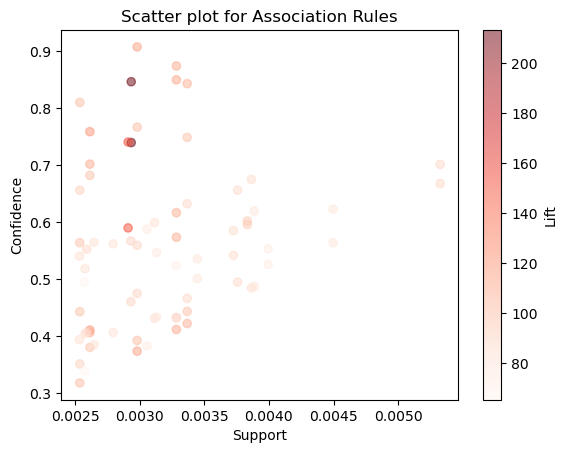

In [28]:
# Scatter plot for association rules
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, c=rules['lift'], cmap='Reds')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Scatter plot for Association Rules')
plt.show()

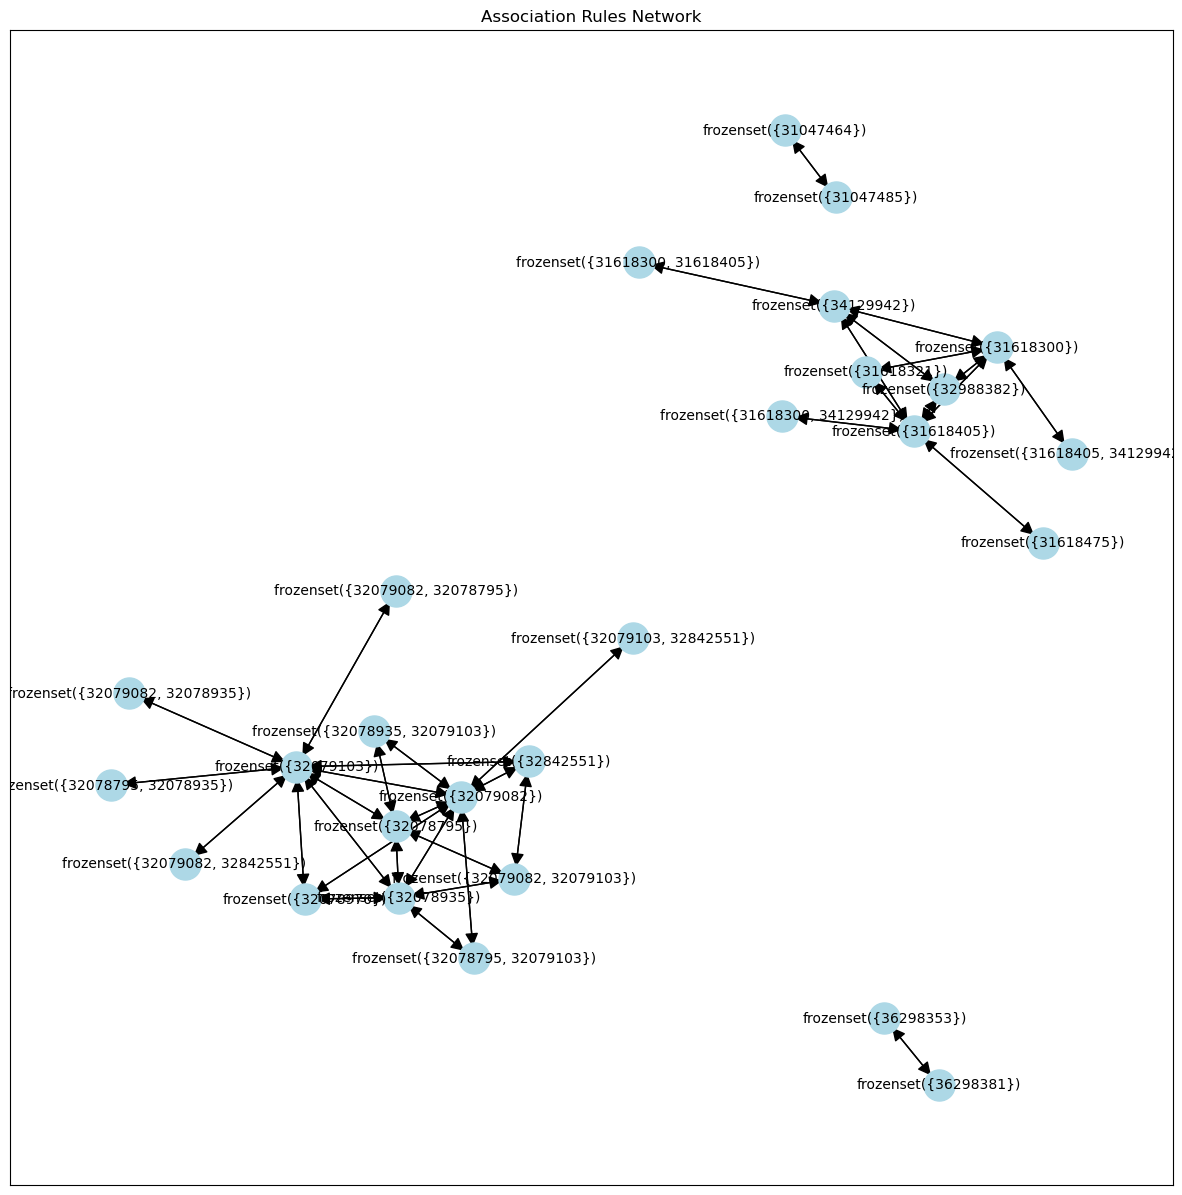

In [34]:
# Create a networkx graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in rules.iterrows():
    G.add_node(row['antecedents'], label=str(row['antecedents']))
    G.add_node(row['consequents'], label=str(row['consequents']))
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

# Draw the graph
pos = nx.spring_layout(G, k=2)  # positions for all nodes
plt.figure(figsize=(15, 15))

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

# Edges
edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Association Rules Network')
plt.show()